In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    

In [3]:
train = pd.read_csv("../data/train_nocat.csv")
test = pd.read_csv("../data/test_nocat.csv")

In [4]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

### Creat lag ahead scenarios

In [5]:
#create 48 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)

#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_w.shape, ahead_e.shape

((13991, 392), (13991, 49), (13991, 8))

In [19]:
#create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)

#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_wt.shape, ahead_et.shape

((5775, 392), (5775, 49))

## Autosklearn

In [158]:
import autosklearn.regression as autoreg

cls = autoreg.AutoSklearnRegressor(time_left_for_this_task=300, 
                                   per_run_time_limit=100, 
                                   initial_configurations_via_metalearning=0,
                                   ensemble_size=100, 
                                   ensemble_nbest=20, 
                                   ensemble_memory_limit=2048, 
                                   seed=1, ml_memory_limit=4096, 
                                   include_estimators=None, 
                                   exclude_estimators=None, 
                                   include_preprocessors=None, 
                                   exclude_preprocessors=None, 
                                   resampling_strategy='holdout', 
                                   resampling_strategy_arguments={'train_size':0.8,
                                                                  'shuffle':True}, 
                                   tmp_folder=None, 
                                   output_folder=None, 
                                   delete_tmp_folder_after_terminate=True, 
                                   delete_output_folder_after_terminate=True, 
                                   shared_mode=False, 
                                   n_jobs = 6, 
                                   disable_evaluator_output=False, 
                                   get_smac_object_callback=None, 
                                   smac_scenario_args=None, 
                                   logging_config=None, 
                                   metadata_directory=None)

cls.fit(ahead_w.iloc[:10000,:8], ahead_e.iloc[:10000,1:2])
yhat = cls.predict(ahead_wt.iloc[:100,:8])


/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/charles/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was pass

[WARNING] [2020-03-19 00:05:11,640:EnsembleBuilder(1791095845):39b0911e81bc3fd550a9cf9a974651ad] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 00:05:11,648:EnsembleBuilder(1791095845):39b0911e81bc3fd550a9cf9a974651ad] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 00:05:13,653:EnsembleBuilder(1791095845):39b0911e81bc3fd550a9cf9a974651ad] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 00:05:15,677:EnsembleBuilder(1791095845):39b0911e81bc3fd550a9cf9a974651ad] No models better than random - using Dummy Score!
[WARNING] [2020-03-19 00:05:17,686:EnsembleBuilder(1791095845):39b0911e81bc3fd550a9cf9a974651ad] No models better than random - using Dummy Score!


In [167]:
cls.get_models_with_weights()

[(0.55,
  SimpleRegressionPipeline({'categorical_encoding:__choice__': 'one_hot_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'random_forest', 'rescaling:__choice__': 'standardize', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 1.0, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 1, 'regressor:random_forest:min_samples_split': 2, 'regressor:random_forest:min_weight_fraction_leaf': 0.0, 'regressor:random_forest:n_estimators': 100, 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.01},
  dataset_properties={
    'task': 4,
    'sparse': False,
    'multilabel': False,
    'multiclass': False,
    'target_type': 'regress

In [162]:
y_test = ahead_et.iloc[100:200,1:2]

In [161]:
yhat = cls.predict(ahead_wt.iloc[100:200,:8])

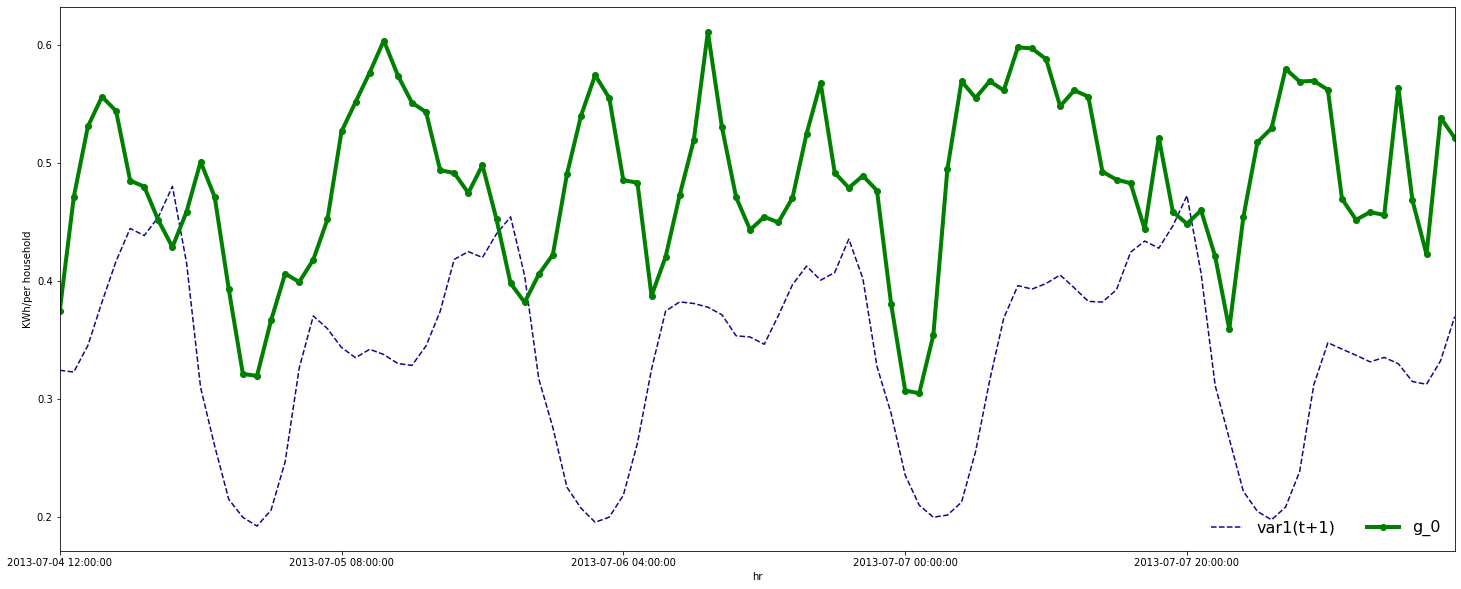

In [163]:
## assignment
real = y_test
guess = yhat.reshape(1,-1)

rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()

real.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
gpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)

#ax.plot(guess,c='g')
#ax.plot(real)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

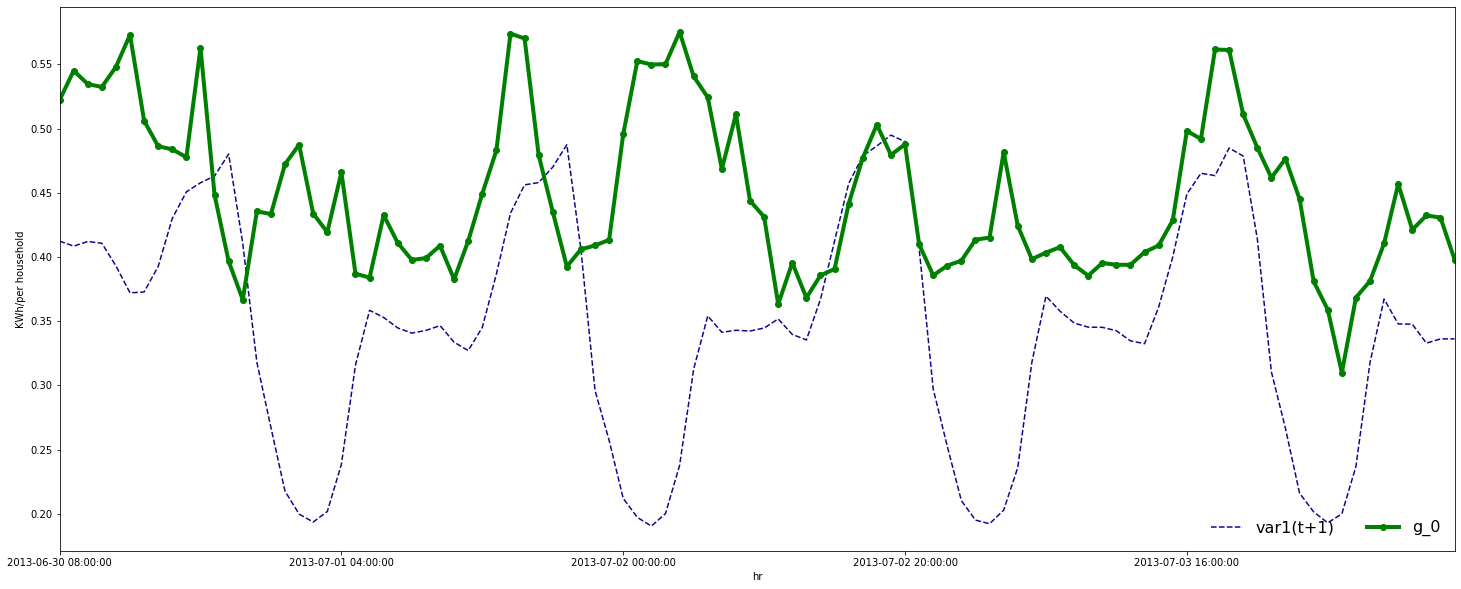

In [151]:
## assignment
real = y_test
guess = yhat.reshape(1,-1)

rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()

real.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
gpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)

#ax.plot(guess,c='g')
#ax.plot(real)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

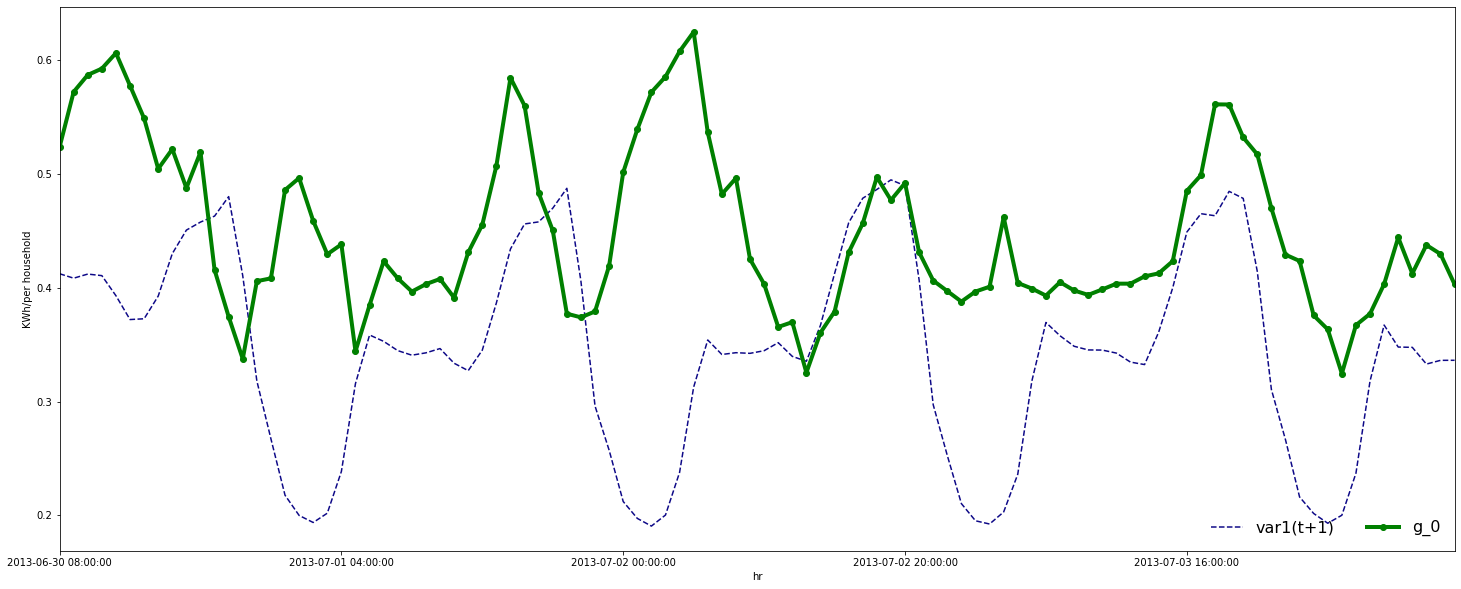

In [148]:
## assignment
real = y_test
guess = yhat.reshape(1,-1)

rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()

real.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
gpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)

#ax.plot(guess,c='g')
#ax.plot(real)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()



### Scaling 

In [6]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ahead_w)
mt = mmscaler.transform(ahead_w)


### Feature Selection

In [7]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None, min_samples_split=10, 
                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.0).fit(mt, ahead_e)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(mt)
cols ## the selected features column

array([ 70,  98,  99, 100, 102, 104, 105, 106, 107, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126,
       127, 128, 130, 132, 133, 134, 135, 136, 144, 145, 245, 247, 249,
       250, 252, 253, 256, 257, 260, 262, 264, 265, 268, 270, 271, 276,
       277, 279, 284, 285, 287, 289, 325, 343, 344, 348, 350, 351, 353,
       358, 363, 365, 366, 370, 371, 376, 377, 378, 379, 382, 383, 385,
       387, 389])



### Random Forest Regression: Manual ML

In [8]:
from sklearn.ensemble import RandomForestRegressor

X = mt_feature
y = ahead_e

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

#for i in range(50):
rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [9]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

**Root Mean Square Error**

In [10]:
mean_squared_error(val_y, yhat)

0.0040460252512681105

**Mean Absolute Error**

In [11]:
mean_absolute_error(val_y, yhat)

0.04803145596644684

**R2 score**

In [12]:
r2_score(val_y, yhat)

0.8281609629157657

**Visualization**

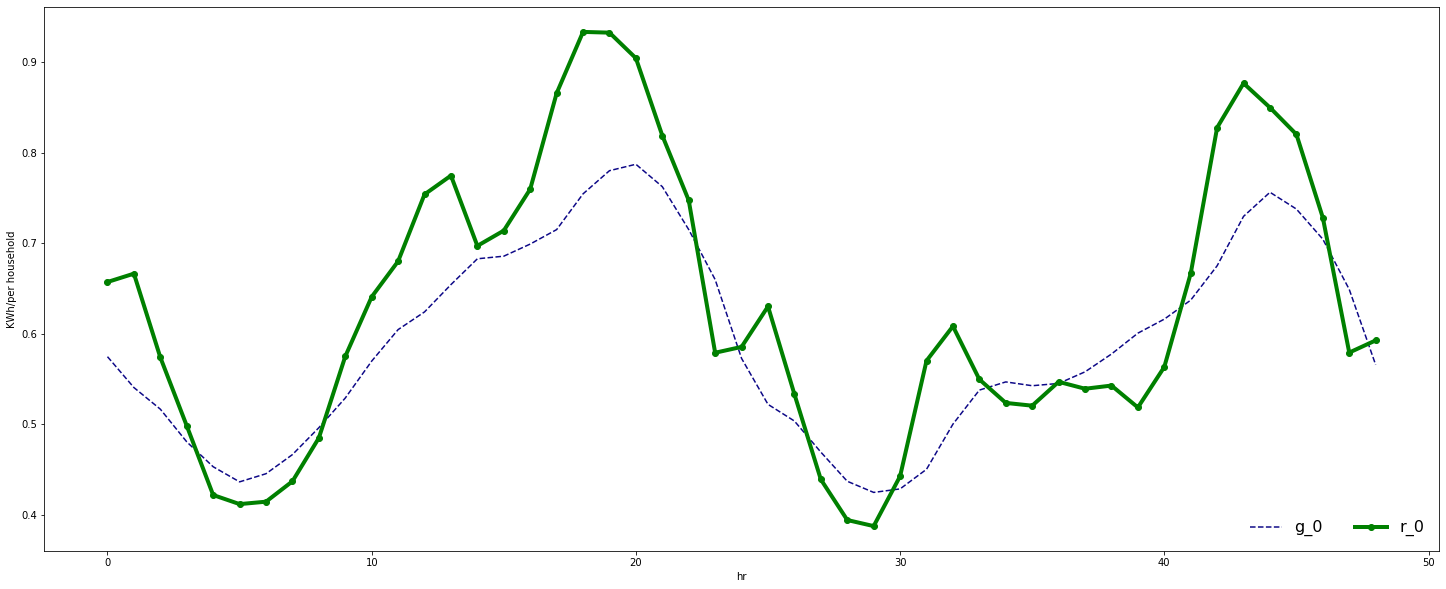

In [32]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[1000:1001,:49]
guess = guess[1000:1001,:49]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [15]:
## create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
#single_wt = train.iloc[:5775,:8]
#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_wt.shape, ahead_et.shape

((5775, 392), (5775, 49))

In [16]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ahead_wt)

In [17]:
## feature pick up
test_x = mtest[:,cols]
test_y = ahead_et

In [18]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

In [22]:
yt_hat.shape

(5775, 49)

In [23]:
test_y.shape

(5775, 49)

**Performance**

In [25]:
get_eval(test_y, yt_hat)

MSE: 0.006780613011683417
MAE: 0.060673154449961096
r2_score: 0.6850708959238484


**Visualization**

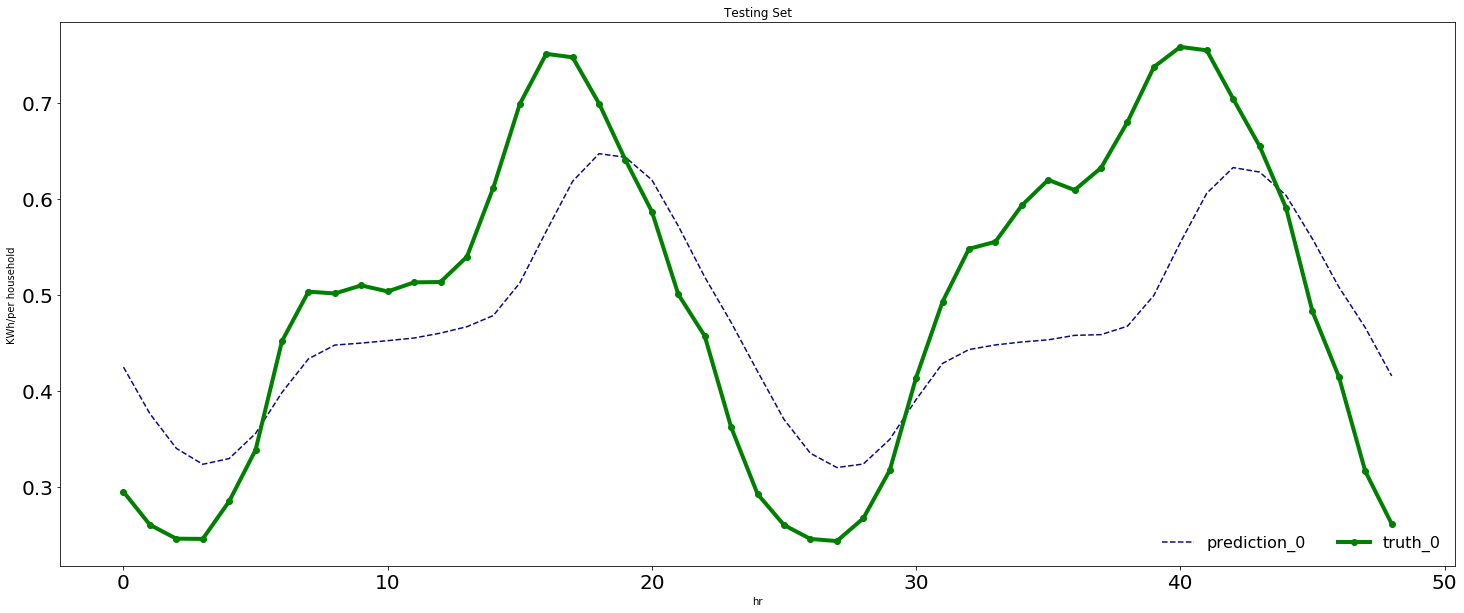

In [45]:
real = test_y.to_numpy()
guess = yt_hat
real = real[4000:4001,:49]
guess = guess[4000:4001,:49]
rpdf = plot_df(real,"truth")
gpdf = plot_df(guess,"prediction")
    
#plot 
ax = plt.gca()
ax.title.set_size(20)

gpdf.plot(title = "Testing Set", figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax,fontsize= 20)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Xgboost: Manual

In [52]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = mt_feature
y = ahead_e
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 8)
#mr = MultiOutputRegressor(xgbr, n_jobs = 4)
#mr.fit(train_X, train_y)
rc = RegressorChain(xgbr, cv = 5, random_state = 123)
rc.fit(train_X, train_y)

[22:59:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:18:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:43:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:10:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RegressorChain(base_estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           importance_type='gain',
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=10, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, njobs=8, nthread=None,
                                           objective='reg:linear',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=

### Result evaluation: test set

In [76]:
yhat = mr.predict(val_X)

In [77]:
get_eval(val_y, yhat)

MSE: 0.0009407807361554104
MAE: 0.015613013013415871
r2_score: 0.9601076576134726


**Visualization**

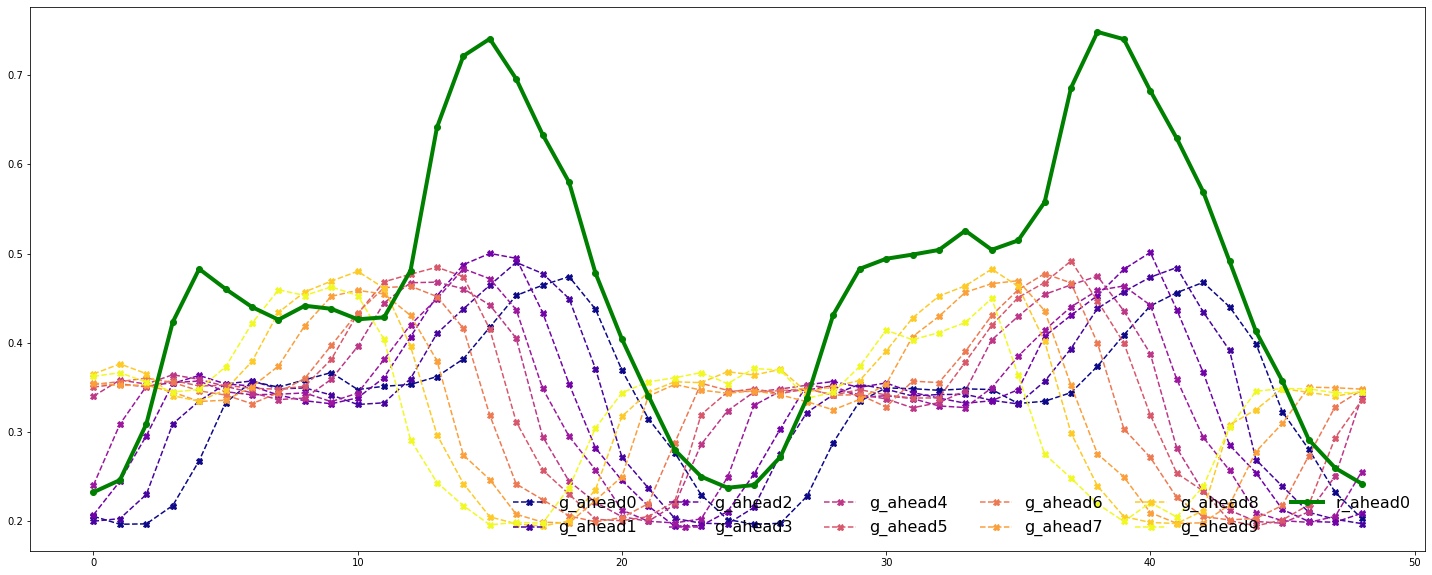

In [129]:
real = val_y.to_numpy()
guess = yhat
real = real[90:91,:49]
guess = guess[90:100,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Result evaluation: test set

In [110]:
yhat = rc.predict(test_x)

In [111]:
get_eval(test_y, yhat)

MSE: 0.006146311995818374
MAE: 0.055119984116775565
r2_score: 0.7145231955924491


**Visualization**


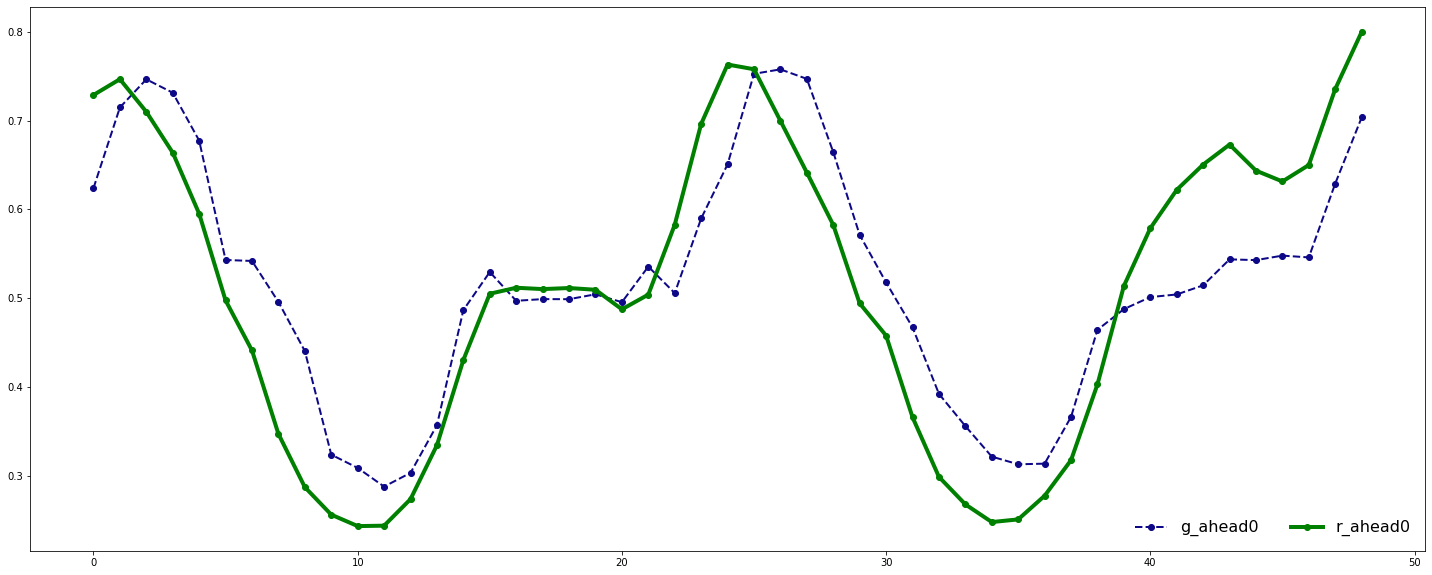

In [114]:
real = test_y.to_numpy()
guess = yhat
real = real[5000:5001,:49]
guess = guess[5000:5001,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--o',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

In [80]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(X_new, y_train_minmax, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

AttributeError: 'DataFrame' object has no attribute 'reshape'

**performace**


In [46]:
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.098


In [43]:
#data preprocess
real = test_y
guess = yhat

real = real[:1,:]
guess = guess[:1,:]

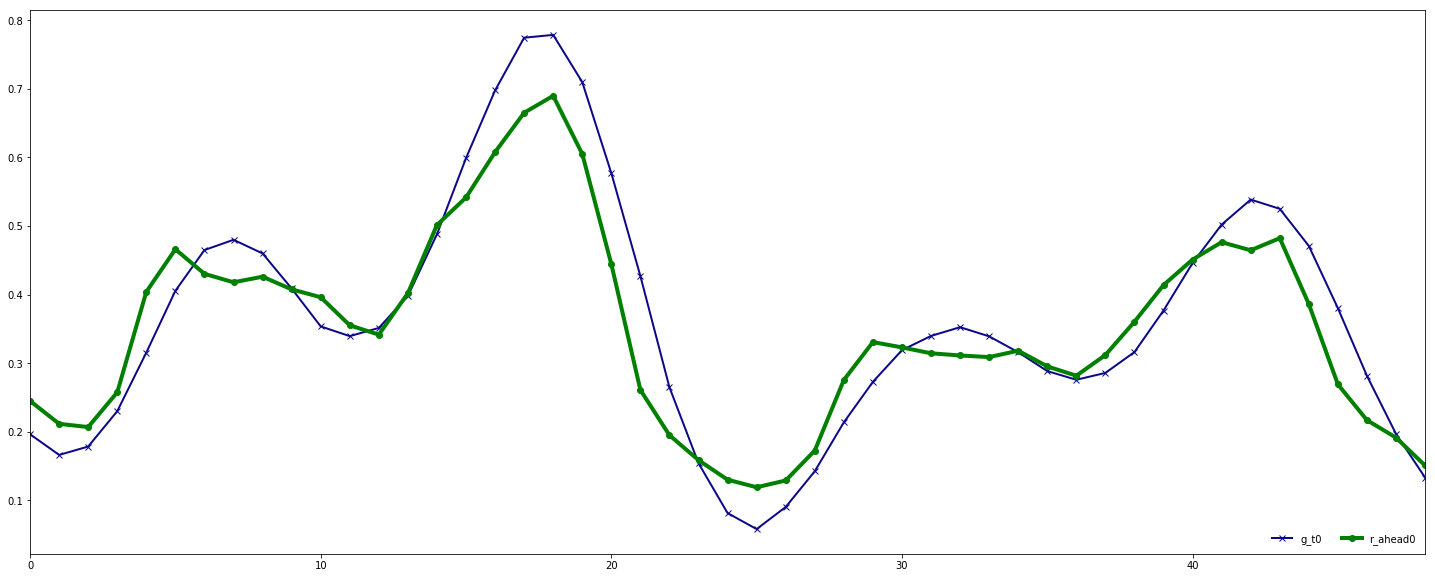

In [45]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

ax = plt.gca()

    
#plot 
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()